<a href="https://colab.research.google.com/github/luisashimabucoro/NMA-Project-Code-Summarization/blob/main/Code2Doc_usingGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preliminaries**

In [84]:
!pip install transformers &> /dev/null

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import io
import re
import math
import random
import unicodedata

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from tqdm.notebook import tqdm
from sklearn.utils import shuffle


import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [85]:
# mount gdrive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Basic EDA**

In [86]:
data_df = pd.read_json('/content/gdrive/Shareddrives/Dolma2/Datasets/python/train.jsonl', lines=True)

In [87]:
data_df[:5] # samples

,repo,path,func_name,original_string,language,code,code_tokens,docstring,docstring_tokens,sha,url,partition
0,smdabdoub/phylotoast,phylotoast/util.py,split_phylogeny,"def split_phylogeny(p, level=""s""):\n """"""\n ...",python,"def split_phylogeny(p, level=""s""):\n """"""\n ...","[def, split_phylogeny, (, p, ,, level, =, ""s"",...",Return either the full or truncated version of...,"[Return, either, the, full, or, truncated, ver...",0b74ef171e6a84761710548501dfac71285a58a3,https://github.com/smdabdoub/phylotoast/blob/0...,train
1,smdabdoub/phylotoast,phylotoast/util.py,ensure_dir,"def ensure_dir(d):\n """"""\n Check to make...",python,"def ensure_dir(d):\n """"""\n Check to make...","[def, ensure_dir, (, d, ), :, if, not, os, ., ...",Check to make sure the supplied directory path...,"[Check, to, make, sure, the, supplied, directo...",0b74ef171e6a84761710548501dfac71285a58a3,https://github.com/smdabdoub/phylotoast/blob/0...,train
2,smdabdoub/phylotoast,phylotoast/util.py,file_handle,"def file_handle(fnh, mode=""rU""):\n """"""\n ...",python,"def file_handle(fnh, mode=""rU""):\n """"""\n ...","[def, file_handle, (, fnh, ,, mode, =, ""rU"", )...",Takes either a file path or an open file handl...,"[Takes, either, a, file, path, or, an, open, f...",0b74ef171e6a84761710548501dfac71285a58a3,https://github.com/smdabdoub/phylotoast/blob/0...,train
3,smdabdoub/phylotoast,phylotoast/util.py,gather_categories,"def gather_categories(imap, header, categories...",python,"def gather_categories(imap, header, categories...","[def, gather_categories, (, imap, ,, header, ,...",Find the user specified categories in the map ...,"[Find, the, user, specified, categories, in, t...",0b74ef171e6a84761710548501dfac71285a58a3,https://github.com/smdabdoub/phylotoast/blob/0...,train
4,smdabdoub/phylotoast,phylotoast/util.py,parse_unifrac,"def parse_unifrac(unifracFN):\n """"""\n Pa...",python,"def parse_unifrac(unifracFN):\n """"""\n Pa...","[def, parse_unifrac, (, unifracFN, ), :, with,...",Parses the unifrac results file into a diction...,"[Parses, the, unifrac, results, file, into, a,...",0b74ef171e6a84761710548501dfac71285a58a3,https://github.com/smdabdoub/phylotoast/blob/0...,train


In [88]:
train_df = data_df.loc[:,['code_tokens', 'docstring_tokens']].head(300) # removing extra columns
train_df

,code_tokens,docstring_tokens
0,"[def, split_phylogeny, (, p, ,, level, =, ""s"",...","[Return, either, the, full, or, truncated, ver..."
1,"[def, ensure_dir, (, d, ), :, if, not, os, ., ...","[Check, to, make, sure, the, supplied, directo..."
2,"[def, file_handle, (, fnh, ,, mode, =, ""rU"", )...","[Takes, either, a, file, path, or, an, open, f..."
3,"[def, gather_categories, (, imap, ,, header, ,...","[Find, the, user, specified, categories, in, t..."
4,"[def, parse_unifrac, (, unifracFN, ), :, with,...","[Parses, the, unifrac, results, file, into, a,..."
...,...,...
295,"[def, _prepare_defaults, (, self, ), :, for, n...","[Trigger, assignment, of, default, values, .]"
296,"[def, from_mongo, (, cls, ,, doc, ), :, if, do...","[Convert, data, coming, in, from, the, MongoDB..."
297,"[def, pop, (, self, ,, name, ,, default, =, SE...","[Retrieve, and, remove, a, value, from, the, b..."
298,"[def, _op, (, self, ,, operation, ,, other, ,,...","[A, basic, operation, operating, on, a, single..."


In [89]:
# list(train_df['docstring_tokens']" ".join())
for i in train_df['docstring_tokens']:
  j = " ".join(i)
  print(j)
  break

Return either the full or truncated version of a QIIME - formatted taxonomy string .


In [90]:
docstring = list(train_df['docstring_tokens'].apply(lambda x: " ".join(x)))
code = list(train_df['code_tokens'].apply(lambda x: " ".join(x)))
combined = []
for i, x in enumerate(docstring):
  pair = []
  pair.append(docstring[i])
  pair.append(code[i])
  combined.append(pair)
  print(combined)
  break

[['Return either the full or truncated version of a QIIME - formatted taxonomy string .', 'def split_phylogeny ( p , level = "s" ) : level = level + "__" result = p . split ( level ) return result [ 0 ] + level + result [ 1 ] . split ( ";" ) [ 0 ]']]


In [91]:
SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
    self.n_words = 3  # Count SOS and EOS and PAD

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1


def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
  )


def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s


def readLangs(lang1, lang2, data, reverse=False):
  print("Reading lines...")

  docstring = list(train_df['docstring_tokens'].apply(lambda x: " ".join(x)))
  code = list(train_df['code_tokens'].apply(lambda x: " ".join(x)))
  combined = []
  for i, x in enumerate(docstring):
    pair = []
    pair.append(docstring[i])
    pair.append(code[i])
    combined.append(pair)
    #print(combined[:5])
  '''
  # Read the file and split into lines
  lines = io.open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
      read().strip().split('\n')

  # Split every line into pairs and normalize
  pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
  print(pairs[-5:])

  train_df
  '''

  # Reverse pairs, make Lang instances
  if reverse:
      pairs = [list(reversed(p)) for p in combined]
      input_lang = Lang(lang2)
      output_lang = Lang(lang1)
  else:
      input_lang = Lang(lang1)
      output_lang = Lang(lang2)
  print(combined)
  return input_lang, output_lang, combined

In [92]:
MAX_LENGTH = 1000

def filterPair(p):
  return len(p[0].split(' ')) < MAX_LENGTH and \
      len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]



In [93]:
def prepareData(lang1, lang2, data, reverse=False):
  input_lang, output_lang, pairs = readLangs(lang1, lang2, data, reverse)
  print(pairs)
  print("Read %s sentence pairs" % len(pairs))
  pairs = filterPairs(pairs)
  print(pairs)
  print("Trimmed to %s sentence pairs" % len(pairs))
  print("Counting words...")
  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Counted words:")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('cod', 'des', train_df, True)
print(pairs)

Reading lines...
[['Return either the full or truncated version of a QIIME - formatted taxonomy string .', 'def split_phylogeny ( p , level = "s" ) : level = level + "__" result = p . split ( level ) return result [ 0 ] + level + result [ 1 ] . split ( ";" ) [ 0 ]'], ['Check to make sure the supplied directory path does not exist if so create it . The method catches OSError exceptions and returns a descriptive message instead of re - raising the error .', 'def ensure_dir ( d ) : if not os . path . exists ( d ) : try : os . makedirs ( d ) except OSError as oe : if os . errno == errno . ENOENT : msg = twdd ( ) return msg . format ( d ) else : msg = twdd ( ) return msg . format ( d , oe . strerror )'], ['Takes either a file path or an open file handle checks validity and returns an open file handle or raises an appropriate Exception .', 'def file_handle ( fnh , mode = "rU" ) : handle = None if isinstance ( fnh , file ) : if fnh . closed : raise ValueError ( "Input file is closed." ) handl

In [94]:
def plot_lang(lang, top_k=100):
  words = list(lang.word2count.keys())
  words.sort(key=lambda w: lang.word2count[w], reverse=True)
  print(words[:top_k])
  count_occurences = sum(lang.word2count.values())

  accumulated = 0
  counter = 0

  while accumulated < count_occurences * 0.8:
    accumulated += lang.word2count[words[counter]]
    counter += 1

  print(f"The {counter * 100 / len(words)}% most common words "
        f"account for the {accumulated * 100 / count_occurences}% of the occurrences")
  plt.bar(range(100), [lang.word2count[w] for w in words[:top_k]])
  plt.show()

['.', 'the', 'a', 'to', 'of', 'for', 'and', '-', 'in', 'from', 'file', 'with', 'on', 'is', 'or', 'that', 'if', 'parse', 'given', 'not', 'each', 'as', 'data', 'by', 'an', 'convert', 'get', 'Returns', 'list', 'default', 'make', 'specified', 'have', 'genome', 'remove', 'format', 'value', 'table', 'string', 'it', 'return', 'all', 'based', 'sequences', 'fasta', 'files', 'image', 'If', 'at', 'print', 'are', 'unique', 'be', 'Return', 'path', 'dictionary', 'values', 'set', 'function', 'reads', 'sequence', 'calculate', 'one', 'version', 'type', 'OTU', 'single', 'sam', 'object', 'output', 'Steam', 'custom', 'Default', 'returns', 'will', 'into', 'then', 'read', 'abundance', 'number', 'ID', 'line', 'bit', 'coverage', 'whether', 'insertion', 'validation', 'sure', 'directory', 'does', 'The', 'user', 'mapping', 'group', 'Calculate', 'sample', 'Compute', 'command', 'entri', 'Mengembalikan']
The 40.55299539170507% most common words account for the 80.03067484662577% of the occurrences


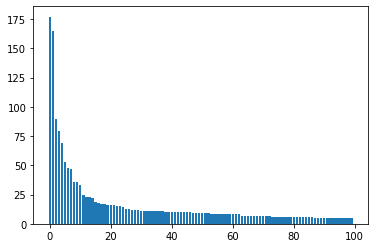

In [95]:
plot_lang(input_lang)

['(', ')', ',', '.', '=', ':', '[', ']', 'if', '', 'self', 'in', 'for', '1', '0', 'return', 'def', 'line', 'not', 'i', 'append', '==', 'else', 'is', 'False', 'None', 'split', '%', '+', '-', 'and', 'seq', '{', '}', 'True', 'len', 'c', 'name', 'join', 'path', 'print', "'", 'genome', 'args', 'gff', 'kwargs', 'os', 'prop', '*', 'value', 'yield', 't', 'f', 'file', 'header', 'info', 'elif', 'strip', 'list', 'b', 'float', 'a', 'fasta', 'id', 'or', '**', "''", 'values', '+=', '!=', 'start', 'insertion', '>', '2', 'register', 'out', 'strand', 'continue', 'index', 'table', 'format', 'ID', 'rsplit', 'hits', 'except', 'int', "'.'", 'k', 'parser', 'sys', 'try', 'raise', 'length', '%s', 'fastas', 'p', 'items', 'add_argument', 'help', 'read']
The 9.073958980733375% most common words account for the 80.02407773669275% of the occurrences


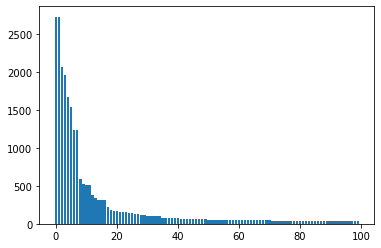

In [96]:
plot_lang(output_lang)

In [97]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

  def forward(self, input, hidden):
    embedded = self.embedding(input)#.view(1, 1, -1)
    output = embedded
    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self, batch_size):
    return torch.zeros(1, batch_size, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self, input, hidden):
    output = self.embedding(input)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.softmax(self.out(output))
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

def to_train(input_lang, output_lang, pairs, max_len=MAX_LENGTH+2):
  x_input = []
  x_output = []
  target = []
  for i, o in pairs:
    s_i = [2] * max_len + [0] + [input_lang.word2index[w] for w in i.split(" ")] + [1]
    s_o = [0] + [output_lang.word2index[w] for w in o.split(" ")] + [1] + [2] * max_len
    s_to = s_o[1:] + [2]
    x_input.append(s_i[-max_len:])
    x_output.append(s_o[:max_len])
    target.append(s_to[:max_len])
  return x_input, x_output, target

In [98]:
x_input, x_partial, y = to_train(input_lang, output_lang, pairs)

In [99]:
print('Representation of an input sentece:')
print(x_input[0])
print(' '.join([input_lang.index2word[w] for w in x_input[0]]))
print('\nRepresentation of an partial sentece:')
print(x_partial[0])
print(' '.join([output_lang.index2word[w] for w in x_partial[0]]))
print('\nRepresentation of an target sentece:')
print(y[0])
print(' '.join([output_lang.index2word[w] for w in y[0]]))

Representation of an input sentece:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [100]:
def predict(encoder, decoder, input, output):
  _, hidden = encoder(input, encoder.initHidden(input.shape[0]))
  out, _ = decoder(output, hidden)
  return out

def train(encoder, decoder, loss, input, output, target, learning_rate=0.001, epochs=10, batch_size=100):

  plot_losses = []
  plot_full_losses = []

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

  for _ in tqdm(range(epochs)):
    c_input, c_output, c_target = shuffle(input, output, target)
    c_input = torch.tensor(c_input, dtype=torch.long, device=device)
    c_output = torch.tensor(c_output, dtype=torch.long, device=device)
    c_target = torch.tensor(c_target, dtype=torch.long, device=device)
    acc_loss = 0
    for i in range(0, c_target.shape[0], batch_size):
      c_batch_size = c_target[i:i+batch_size, ...].shape[0]
      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()

      out = predict(encoder, decoder, c_input[i:i+batch_size, ...], c_output[i:i+batch_size, ...])
      #Reshapes the output and target to use the expected loss format.
      # N x Classes for the output
      # N for the targets
      # Where N is the batch size
      out = out.reshape(c_batch_size * c_input.shape[1], -1)
      r_target = c_target[i:i+batch_size, ...].reshape(c_batch_size * c_input.shape[1])

      c_loss = loss(out, r_target)
      # Mask the errors for padding as they are not usefull!
      valid = torch.where(r_target == 2, 0, 1)
      c_loss = c_loss * valid
      c_loss = torch.sum(c_loss) #/ torch.sum(valid)

      c_loss.backward()

      encoder_optimizer.step()
      decoder_optimizer.step()
      plot_full_losses.append(c_loss.detach().cpu().numpy())
      acc_loss += c_loss.detach().cpu().numpy()
    plot_losses.append(acc_loss /math.ceil(c_target.shape[0] / batch_size))
  return plot_losses, plot_full_losses

In [101]:
hidden_size = 300
num_epochs = 10  # Change this to 50 (original value!)
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
epoch_error, batch_error = train(encoder, decoder,
                                 nn.NLLLoss(reduction='none'),
                                 x_input, x_partial, y,
                                 epochs=num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

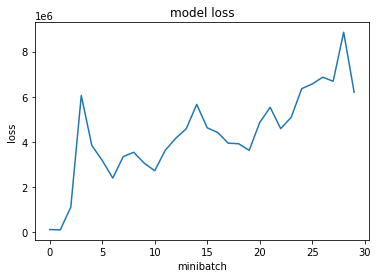

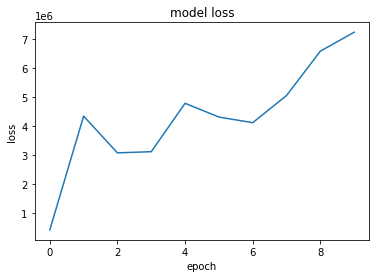

In [102]:
#print(epoch_error)
#print(batch_error)

plt.plot(batch_error)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('minibatch')
plt.show()

plt.plot(epoch_error)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [105]:
p = predict(encoder, decoder, torch.tensor([x_input[100]],
                                           dtype=torch.long,
                                           device=device),
            torch.tensor([x_partial[100]], dtype=torch.long, device=device))

p = p.detach().cpu().numpy()

In [106]:
print(np.argmax(p, axis=-1))
print(x_partial[40])

[[ 50 665 665 ... 665 665 665]]
[0, 3, 727, 5, 220, 7, 728, 11, 12, 729, 9, 728, 16, 678, 5, 155, 9, 730, 11, 731, 9, 728, 16, 678, 5, 155, 9, 732, 11, 733, 9, 728, 16, 678, 5, 155, 9, 734, 11, 26, 729, 12, 729, 9, 729, 16, 735, 5, 736, 11, 26, 731, 12, 220, 16, 729, 9, 66, 731, 16, 491, 16, 116, 5, 11, 12, 731, 19, 737, 21, 16, 116, 5, 11, 71, 220, 16, 738, 9, 731, 16, 739, 16, 116, 5, 11, 220, 16, 738, 214, 693, 693, 13, 728, 16, 678, 5, 155, 9, 740, 11, 16, 491, 16, 116, 5, 11, 43, 12, 220, 16, 729, 9, 66, 95, 16, 491, 16, 116, 5, 11, 12, 95, 19, 737, 21, 16, 116, 5, 11, 75, 95, 76, 729, 71, 26, 729, 43, 66, 71, 220, 16, 733, 9, 733, 16, 491, 16, 116, 5, 11, 26, 733, 43, 192, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [110]:
def gen_translation(encoder, decoder, text, input_lang, output_lang,
                    max_len=MAX_LENGTH+2):

  text =  [2] * max_len + [0] + [input_lang.word2index[w] for w in text.split(" ")] + [1]
  text = torch.tensor([text[-max_len:]], dtype=torch.long, device=device)
  out = [0] + [2] * max_len
  out = [out[:max_len]]
  for i in range(1, max_len):
    pt_out =torch.tensor(out, dtype=torch.long, device=device)
    p = predict(encoder, decoder, text, pt_out).detach().cpu().numpy()
    out[0][i] = np.argmax(p, axis=-1)[0, i-1]
    if np.argmax(p, axis=-1)[0, i-1] == 1:
      break

  return ' '.join([output_lang.index2word[idx] for idx in out[0]])

In [111]:
gen_translation(encoder, decoder, pairs[40][0], input_lang, output_lang)

'SOS None kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwargs kwa

In [ ]:
for i in range(40):
  print('> {}'.format(pairs[i][0]))
  print('= {}'.format(pairs[i][1]))
  print('< {}'.format(gen_translation(encoder, decoder,
                                      pairs[i][0],
                                      input_lang,
                                      output_lang)))
  print('*' * 40)